## **Principal Component Analysis & Kmeans Clustering**

#### Reflection exercises for each group:

1. At the top of the Colab notebook that you share with everyone, please include your responses to the following questions:
  - Choose at least 1 dataset to explore in more detail.
    - We are analyzing SDR (surface directional reflectance) from NEON for the Harvard (HARV) location during 2016
  - What is the projection for this dataset?
    - Projected coordinate system is EPSG:32618
  - Where can you find more information on how the data were collected and how to interpret the metadata?
    - The NEON website has the metadata and other related information
  - Think about what data type each variable is.
    - Raster
  - Is it vector or raster data? What properties exist for each dataset?
    - The SDR is raster data. There are 442 properties, including flight year, NEON site, sensor name, all the numbered bands (B001-B26), other bands including and aerosol, cast show, etc.
  - What resolution are your data?
    - The raw data was 1m in resolution. The code changes the SDR to 300m resolution for processing purposes.
2. At the top of the Colab notebook, write a short summary detailing the processing steps in the notebook and your results.

  - For the principal component analysis (pca), we used the pca helper function to setup the variables and create relationships necessary to run the pca. We then imported the SDR data and filter it by HARV and 2016. To input the SDR data into the pca, we cleaned up the band data to include only necessary bands and get rid of negative values. We then reduced the spatial (projected to 300m resolution) and spectral resolution (removing every 10th band). Then we ran the pca and create a map visual. In the map, it shows the first three principal components, visualizing them using the RGB spectrum. The colors of the pixels show the similarities between pixels of SDR data. The closer the properties are, the more similar in color they should be.
  We also added an interactive option to select pixels in the map and show the surface reflectance. This can be changed to the raw SDR values, but is currently set to the cleaned up band data.
  
  For the K means clustering, we are grouping the spectral distance between pixels by 3 and 10 clusters. Once again visualized using RGB spectrum.

  - Although these topics may be far removed from your own interests, how could these steps and analyses help in your own work?
    - Visualization tools are helpful. I could make a PCA to see how similar my sites are using landsat images.
    -

3. OPTIONAL - Expand your script by adding additional processing, analysis, or other data.

As you're working through your exercise, **add code chunks to further document your scripts. Add additional comments to the code itself to clarify complicated processes.**




---



In [ ]:
import numpy as np
import ee
import geemap
import geemap.colormaps as cm
ee.Authenticate()
ee.Initialize(project='ee-seeds-gis')
geemap.ee_initialize(project='ee-seeds-gis')

In [ ]:
############### PCA Helper Functions (from GEE documentation linked below) ###############
# From GEE: https://developers.google.com/earth-engine/guides/arrays_eigen_analysis

def get_principal_components(centered, scale, region):
  '''INPUTS:
  centered: a mean zero image,
  scale: int
  region: geometry over which to perform analysis
  RETURNS:
  P-band image, normalized by SD
  '''
  numBands = centered.bandNames().length()
  # Collapse bands into 1D array
  arrays = centered.toArray()

  # Compute the covariance of the bands within the region.
  covar = arrays.reduceRegion(
      reducer=ee.Reducer.centeredCovariance(),
      geometry=region,
      scale=scale,
      maxPixels=1e9,
  )

  # Get the 'array' covariance result and cast to an array.
  # This represents the band-to-band covariance within the region.
  covar_array = ee.Array(covar.get('array'))

  # Perform an eigen analysis and slice apart the values and vectors.
  eigens = covar_array.eigen()

  # This is a P-length vector of Eigenvalues.
  eigen_values = eigens.slice(1, 0, 1)
  # This is a PxP matrix with eigenvectors in rows.
  eigen_vectors = eigens.slice(1, 1)

  # Convert the array image to 2D arrays for matrix computations.
  array_image = arrays.toArray(1)

  # Left multiply the image array by the matrix of eigenvectors.
  principal_components = ee.Image(eigen_vectors).matrixMultiply(array_image)

  # Turn the square roots of the Eigenvalues into a P-band image.
  sd_image = (
      ee.Image(eigen_values.sqrt())
      .arrayProject([0])
      .arrayFlatten([get_new_band_names('sd', numBands)])
  )

  # Turn the PCs into a P-band image, normalized by SD.
  return (
      # Throw out an an unneeded dimension, [[]] -> [].
      principal_components.arrayProject([0])
      # Make the one band array image a multi-band image, [] -> image.
      .arrayFlatten([get_new_band_names('pc', numBands)])
      # Normalize the PCs by their SDs.
      .divide(sd_image)
  )

def get_new_band_names(prefix, numBands):
  seq = ee.List.sequence(1, numBands)
  return seq.map(lambda b: ee.String(prefix).cat(ee.Number(b).int()))

def PCA(maskedImage, scale, region):
  # image = maskedImage.unmask()
  image = maskedImage
  bandNames = image.bandNames()

  # Mean center the data to enable a faster covariance reducer
  # and an SD stretch of the principal components.
  meanDict = image.reduceRegion(**{
    'reducer': ee.Reducer.mean(),
    'geometry': region,
    'scale': scale,
    'maxPixels': 1e13,
    'tileScale': 16
  })
  means = ee.Image.constant(meanDict.values(bandNames))
  centered = image.subtract(means)

  return get_principal_components(centered, scale, region)

In [ ]:
### Import AOP data ###
# Import the AOP surface directional reflectance (SDR)
aopSDR = ee.ImageCollection('projects/neon-prod-earthengine/assets/DP3-30006-001')
# Import the AOP red-green-blue imagery (RGB)
aopRGB = ee.ImageCollection('projects/neon-prod-earthengine/assets/DP3-30010-001')


### FOR YOU TO FILL IN ###
mySR_data = aopSDR \
  .filterDate('2016-01-01', '2016-12-31') \
  .filterMetadata('NEON_SITE', 'equals', 'HARV') \
  .first()

myRGB_data = aopRGB \
  .filterDate('2016-01-01', '2016-12-31') \
  .filterMetadata('NEON_SITE', 'equals', 'HARV') \
  .first()

### View your selected AOP data ###
# Set up visualization params
RGB_bands = ['B053', 'B035', 'B019'] # These are the band names for the red, green, blue bands in the SDR data
rgbVis = {'min': 0, 'max': 255, 'gamma': 0.8} # This sets a nice range of values for mapping the RGB data
sdrVis = {'min': 0, 'max': 1260, 'gamma': 0.8} # This sets a nice range of values for mapping the RGB data

# Map
m = geemap.Map()
m.addLayer(mySR_data.select(RGB_bands), sdrVis, 'Surface reflectance')
m.addLayer(myRGB_data, rgbVis, 'RGB')
m.centerObject(myRGB_data, 12)

m

#use Global Moran's I to identify spatial autocorrelation


Map(center=[42.48178752104282, -72.22604039090882], controls=(WidgetControl(options=['position', 'transparent_…

In [ ]:
############### Process the SDR image for input to PCA ###############
### Get a list of valid bands ###
# Select the WL_FWHM_B*** band properties (using regex)
properties = mySR_data.toDictionary()
wl_fwhm_dict = properties.select(['WL_FWHM_B+\d{3}'])

# Function to pull out the wavelength values only and convert the string to float
def get_wavelengths(x):
  str_split = ee.String(x).split(',')
  first_elem = ee.Number.parse((str_split.get(0)))
  return first_elem

# Function to pull out the band neames only
def get_bands(x):
  str_split = ee.String(x).split('_')
  return str_split.get(-1)

# Apply the function to the wavelength full-width-half-max list
wavelengths = np.array(wl_fwhm_dict.values().map(get_wavelengths).getInfo())
bands = np.array(wl_fwhm_dict.keys().map(get_bands).getInfo())

# Create list of bands that are not set to -100
# From metadata in SDR images "Wavelengths between 1340-1445nm and 1790-1955nm are set to -100"
masked_bands_indices = ((wavelengths>=1340) & (wavelengths<=1445)) | ((wavelengths >=1790) & (wavelengths <=1955))
valid_bands = bands[~masked_bands_indices]


### Create the reduced resolution SDR image for input to PCA ###
# Set params
SCALE = 300
SKIP_BANDS_NUM = 10

# Get list of valid bands to select (reducing from 426 bands to ~40)
bands_to_select = (
    mySR_data.select('B...')   # pull out reflectance bands
                  .bandNames().slice(0, -1, SKIP_BANDS_NUM)  # only select every 10th band
                  .getInfo()  # convert to python list
  )
bands_to_select = [b for b in bands_to_select if b in valid_bands] # filter out bad bands

# Create a raster where pixels=1 for <10% cloud cover and pixels=0 for >10% cloud cover. This is our mask.
clearWeather = mySR_data.select('Weather_Quality_Indicator').eq(1)

# Create lower spectral and spatial resolution image for input to PCA
mySR_data_coarse =  (
    mySR_data
          .select(bands_to_select) # This step is critical! If you leave the bad bands, you'll get an image where every pixels is nan!
          .reproject(mySR_data.projection().crs(), # reproject to 300m resolution
                     scale=SCALE)
          # .updateMask(jerc_clearWeather) # Optional
)

############### Run PCA ###############
pc_image = PCA(mySR_data_coarse, SCALE, mySR_data_coarse.geometry())


############### Map results ###############
RGBish_bands = ['B051', 'B031', 'B021']
RGBish_vis = {'bands': RGBish_bands, 'min': 0, 'max': 1700, 'opacity': 1.0, 'gamma': 1.0}

m = geemap.Map()
m.addLayer(mySR_data_coarse.select(RGBish_bands), RGBish_vis, 'rgb-ish coarse')
m.addLayer(mySR_data.select(RGBish_bands), RGBish_vis, 'rgb-ish')
m.addLayer(pc_image.select(['pc1', 'pc2', 'pc3']), {'bands': ['pc1', 'pc2', 'pc3'], 'min': -3, 'max': 3, 'opacity': 1.0, 'gamma': 1.0}, 'PCA')
m.centerObject(mySR_data, 12)



#####Add in interactive map to select different pixels
# Helper function called each time we click a new point from neon.aop.
# Select the WL_FWHM_B*** band properties (using regex)
properties = mySR_data.toDictionary()
wl_fwhm_dict = properties.select(['WL_FWHM_B+\d{3}'])

# Pull out the wavelength, fwhm values to a list
wl_fwhm_list = wl_fwhm_dict.values()

# Function to pull out the wavelength values only and convert the string to float
def get_wavelengths(x):
  str_split = ee.String(x).split(',')
  first_elem = ee.Number.parse((str_split.get(0)))
  return first_elem

# apply the function to the wavelength full-width-half-max list
wavelengths = wl_fwhm_list.map(get_wavelengths)

from ipyleaflet import *
from bqplot import pyplot as plt

# Set up variables for plotting markers, reflectance
x = wavelengths.getInfo()
coordinates = []
markers = []
marker_cluster = MarkerCluster(name="Marker Cluster")
m.add_layer(marker_cluster)

# Helper function called each time we click a new point
def handle_interaction(**kwargs):
    latlon = kwargs.get("coordinates")
    if kwargs.get("type") == "click":
      try:
        coordinates.append(latlon)
        markers.append(Marker(location=latlon))
        marker_cluster.markers = markers
        xy = ee.Geometry.Point(latlon[::-1])
        y = mySR_data.select('B.*').sample(xy, 1).first().toDictionary().values().getInfo()
        plt.clear()
        plt.plot(x, y)
      except:
        print('Please click a point inside the box.')


m.on_interaction(handle_interaction)

figure = plt.figure(
    1,
    title="Reflectance",
    layout={"height": "200px", "width": "600px"},
)

fig_control = WidgetControl(widget=figure, position="bottomright")
m.add_control(fig_control)

m

Map(center=[42.481492840062685, -72.21388654644657], controls=(WidgetControl(options=['position', 'transparent…

The clustering code below came from the [Google Earth Engine documentation](https://developers.google.com/earth-engine/guides/clustering), which is an amazing resource! As an **optional extension**, you can check out their example, which uses Landsat data to compare the clusters created with the AOP data to clusters created using Landsat data.

In [ ]:
# Define a region in which to generate a sample of the input.
region = mySR_data.geometry()

# Make the training dataset.
training = pc_image.select(['pc1', 'pc2', 'pc3']).sample(
  region=region,
  scale=SCALE,
  numPixels=5000
  )

# Instantiate the clusterer and train it.
clusterer_3 = ee.Clusterer.wekaKMeans(3).train(training)
clusterer_10 = ee.Clusterer.wekaKMeans(10).train(training)

# Cluster the input using the trained clusterer.
result_3 = pc_image.select(['pc1', 'pc2', 'pc3']).cluster(clusterer_3)
result_10 = pc_image.select(['pc1', 'pc2', 'pc3']).cluster(clusterer_10)


# cluster 0 is blue, cluster 1 is green, cluster 2 is orange
m = geemap.Map()
m.addLayer(region, {}, 'ROI')
m.addLayer(mySR_data_coarse.select(RGBish_bands), RGBish_vis, 'rgb-ish coarse')
m.addLayer(mySR_data.select(RGBish_bands), RGBish_vis, 'rgb-ish')
m.addLayer(result_3.randomVisualizer(), {'bands':['cluster'],'min':0, 'max': 2, 'palette': ['441ABE','19B26E','F27417']}, '3 clusters')
m.addLayer(result_10.randomVisualizer(), {}, '10 clusters')
m.centerObject(pc_image, 12)

m

Map(center=[42.48284226398823, -72.21382765269118], controls=(WidgetControl(options=['position', 'transparent_…



---



## Additional Resources

* **End-to-End Google Earth Engine**: If you'd like to continue exploring the Earth Engine processes and applications, <a href="https://courses.spatialthoughts.com/end-to-end-gee.html#automatic-conversion-of-javascript-code-to-python" target="_blank"> SpatialThoughts Course - Ujaval Gandhi </a> has some nice examples you can follow.



What is the projection system used?

In [ ]:
#how to identify the coordinate system
mySR_proj = mySR_data.projection().getInfo()
print("Projection information for mySR_data:", mySR_proj)

Projection information for mySR_data: {'type': 'Projection', 'crs': 'EPSG:32618', 'transform': [1, 0, 719000, 0, -1, 4719000]}


What is the data type?

In [ ]:
# Get the data type for all bands in the surface directional reflectance data
mySR_dataTypes = mySR_data.bandTypes().getInfo()
print("Data types for mySR_data bands:", mySR_dataTypes)

# Get the data type for all bands in the red-green-blue imagery
myRGB_dataTypes = myRGB_data.bandTypes().getInfo()
print("Data types for myRGB_data bands:", myRGB_dataTypes)

Data types for mySR_data bands: {'Acquisition_Date': {'type': 'PixelType', 'precision': 'float'}, 'Aerosol_Optical_Depth': {'type': 'PixelType', 'precision': 'float'}, 'Aspect': {'type': 'PixelType', 'precision': 'float'}, 'B001': {'type': 'PixelType', 'precision': 'int', 'min': -32768, 'max': 32767}, 'B002': {'type': 'PixelType', 'precision': 'int', 'min': -32768, 'max': 32767}, 'B003': {'type': 'PixelType', 'precision': 'int', 'min': -32768, 'max': 32767}, 'B004': {'type': 'PixelType', 'precision': 'int', 'min': -32768, 'max': 32767}, 'B005': {'type': 'PixelType', 'precision': 'int', 'min': -32768, 'max': 32767}, 'B006': {'type': 'PixelType', 'precision': 'int', 'min': -32768, 'max': 32767}, 'B007': {'type': 'PixelType', 'precision': 'int', 'min': -32768, 'max': 32767}, 'B008': {'type': 'PixelType', 'precision': 'int', 'min': -32768, 'max': 32767}, 'B009': {'type': 'PixelType', 'precision': 'int', 'min': -32768, 'max': 32767}, 'B010': {'type': 'PixelType', 'precision': 'int', 'min': 

In [ ]:
mySR_data

In [ ]:
properties = mySR_data.toDictionary()
properties

##Optional

In [ ]:
## Get the average reflectance value for each wavelength, for each landscape/vegetation type

# Set up for input to reduceRegion
result_3_toReduce = pc_image.select(['pc1', 'pc2', 'pc3']) # just select the wavelength bands
lcbandNum = result_3_toReduce.bandNames().length()
# Apply reduceRegion to the SDR data with landcover
means = result_3_toReduce.addBands(result_3.select('cluster')).reduceRegion(
  reducer=ee.Reducer.mean().repeat(lcbandNum).group(groupField=lcbandNum, groupName='cluster'),
  geometry= result_3_toReduce.geometry(),
  scale=300,
  maxPixels=1e13)
means

In [ ]:
# Create a pandas dataframe from a featureCollection created using the output of reduceRegions
reformatted_means = ee.FeatureCollection(ee.List(means.get('groups')).map(lambda obj: ee.Feature(None, obj)))
lc_wv_df = geemap.ee_to_df(reformatted_means)
lc_wv_df

,cluster,mean
0,0,"[-2.8442500634428085, 0.06776578617339737, 0.2..."
1,1,"[-0.025141157494264398, -0.1285340307652359, -..."
2,2,"[0.5319221663714919, 0.10235872511702991, 0.53..."


In [ ]:
import pandas as pd
import numpy as np
# Clean up the pandas dataframe for plotting
lc_wv_df[['mean_PC1', 'mean_PC2', 'mean_PC3']] = pd.DataFrame(lc_wv_df['mean'].tolist()) # expand the "mean" column into 400+ columns (1 column per wavelength)
lc_wv_df


,cluster,mean,mean_PC1,mean_PC2,mean_PC3
0,0,"[-2.8442500634428085, 0.06776578617339737, 0.2...",-2.844250,0.067766,0.221345
1,1,"[-0.025141157494264398, -0.1285340307652359, -...",-0.025141,-0.128534,-0.642915
2,2,"[0.5319221663714919, 0.10235872511702991, 0.53...",0.531922,0.102359,0.533058


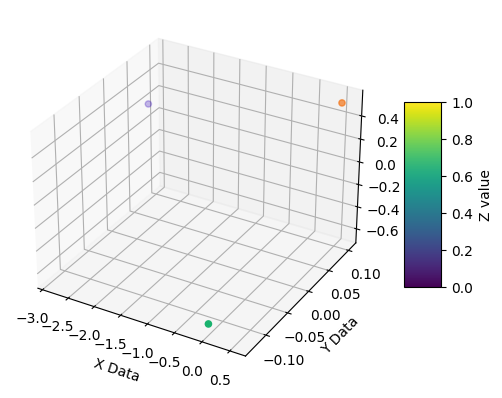

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Convert 'cluster' values to strings
lc_wv_df['cluster'] = lc_wv_df['cluster'].astype(str)

# Recreate the color map with string keys
color_map = {'0': '#441ABE', '1': '#19B26E', '2': '#F27417'}

# Apply the color map to the 'cluster' column
lc_wv_df['color'] = lc_wv_df['cluster'].map(color_map)

x=lc_wv_df.mean_PC1
y=lc_wv_df.mean_PC2
z=lc_wv_df.mean_PC3
colors = lc_wv_df['color']

# Create a new figure
fig = plt.figure()

# Add an axes
ax = fig.add_subplot(111, projection='3d')

# Scatter plot
scatter = ax.scatter(x, y, z, c=colors, marker='o')

# Adding labels
ax.set_xlabel('X Data')
ax.set_ylabel('Y Data')
ax.set_zlabel('Z Data')

# Color bar to show the values of Z
color_bar = fig.colorbar(scatter, ax=ax, shrink=0.5, aspect=5)
color_bar.set_label('Z value')

# Show the plot
plt.show()